In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 1. Разведочный анализ данных (EDA)
print(df.info())
print("Статистика по числовым признакам")
print(df.describe())
print("Проверка на пропуски")
print(df.isnull().sum())

# Целевая переменная 'Churn' - переведем в бинарный вид 1/0
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


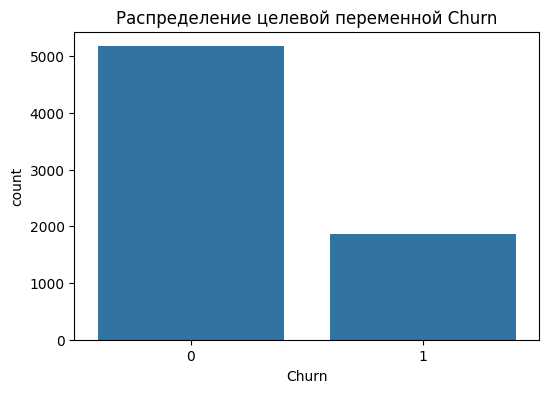

Процент оттока клиентов: 26.54%


In [5]:
# Анализ целевой переменной
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Распределение целевой переменной Churn')
plt.show()
churn_rate = df['Churn'].value_counts(normalize=True)
print(f"Процент оттока клиентов: {churn_rate[1]:.2%}")


In [6]:
# Удалим неинформативный столбец customerID
df.drop('customerID', axis=1, inplace=True)

# Разделим признаки на категориальные и числовые
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('Churn') # Исключаем целевую переменную

print(f"Категориальные признаки: {list(categorical_columns)}")
print(f"Числовые признаки: {list(numerical_columns)}")


Категориальные признаки: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
Числовые признаки: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


### Проверка гипотез

In [7]:
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import numpy as np

print("СТАТИСТИЧЕСКАЯ ПРОВЕРКА ГИПОТЕЗ")

# Создаем отдельную копию для проверки гипотез
df_hypothesis = df.copy()

# 1. ГИПОТЕЗА: Клиенты с помесячным контрактом уходят чаще
print("\n1. ГИПОТЕЗА: Клиенты с помесячным контрактом уходят чаще")

contract_churn_table = pd.crosstab(df_hypothesis['Contract'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(contract_churn_table)
print()

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contract_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

# Расчет относительного риска (Relative Risk) для Month-to-month
month_to_month_churn_rate = contract_churn_table.loc['Month-to-month', 1] / contract_churn_table.loc['Month-to-month'].sum()
one_year_churn_rate = contract_churn_table.loc['One year', 1] / contract_churn_table.loc['One year'].sum()
two_year_churn_rate = contract_churn_table.loc['Two year', 1] / contract_churn_table.loc['Two year'].sum()

print(f"\nПроцент оттока по типам контракта:")
print(f"Month-to-month: {month_to_month_churn_rate:.2%}")
print(f"One year: {one_year_churn_rate:.2%}")
print(f"Two year: {two_year_churn_rate:.2%}")

print(f"\nОтносительный риск (Month-to-month vs Two year): {month_to_month_churn_rate/two_year_churn_rate:.2f}")

if p_value < 0.05:
    print("ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между типом контракта и оттоком")
else:
    print("ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")



# 2. ГИПОТЕЗА: Клиенты с оптоволоконным интернетом уходят чаще
print("\n\n2. ГИПОТЕЗА: Клиенты с оптоволоконным интернетом уходят чаще")

internet_churn_table = pd.crosstab(df_hypothesis['InternetService'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(internet_churn_table)
print()

chi2, p_value, dof, expected = chi2_contingency(internet_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

# Расчет процентов оттока
fiber_churn_rate = internet_churn_table.loc['Fiber optic', 1] / internet_churn_table.loc['Fiber optic'].sum()
dsl_churn_rate = internet_churn_table.loc['DSL', 1] / internet_churn_table.loc['DSL'].sum()
no_internet_churn_rate = internet_churn_table.loc['No', 1] / internet_churn_table.loc['No'].sum()

print(f"\nПроцент оттока по типам интернета:")
print(f"Fiber optic: {fiber_churn_rate:.2%}")
print(f"DSL: {dsl_churn_rate:.2%}")
print(f"No internet: {no_internet_churn_rate:.2%}")

if p_value < 0.05:
    print("ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между типом интернета и оттоком")
else:
    print("ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")



# 3. ГИПОТЕЗА: Время жизни клиента (tenure) влияет на отток
print("\n\n3. ГИПОТЕЗА: Время жизни клиента (tenure) влияет на отток")

# Разделяем на две группы
tenure_stayed = df_hypothesis[df_hypothesis['Churn'] == 0]['tenure']
tenure_churned = df_hypothesis[df_hypothesis['Churn'] == 1]['tenure']

print(f"Среднее время жизни:")
print(f"Не ушли: {tenure_stayed.mean():.2f} месяцев")
print(f"Ушли: {tenure_churned.mean():.2f} месяцев")
print(f"Медиана:")
print(f"Не ушли: {tenure_stayed.median():.2f} месяцев")
print(f"Ушли: {tenure_churned.median():.2f} месяцев")

# T-тест для независимых выборок
t_stat, p_value = ttest_ind(tenure_stayed, tenure_churned, equal_var=False)
print(f"\nT-тест: t = {t_stat:.4f}, p-value = {p_value:.10f}")

# Непараметрический тест Манна-Уитни (более надежный для ненормальных распределений)
u_stat, p_value_mw = mannwhitneyu(tenure_stayed, tenure_churned)
print(f"U-тест Манна-Уитни: U = {u_stat:.0f}, p-value = {p_value_mw:.10f}")

if p_value < 0.05:
    print("ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая разница в времени жизни между группами")
else:
    print("ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой разницы")



# 4. ГИПОТЕЗА: Способ оплаты влияет на отток
print("\n\n4. ГИПОТЕЗА: Способ оплаты влияет на отток")

payment_churn_table = pd.crosstab(df_hypothesis['PaymentMethod'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(payment_churn_table)
print()

chi2, p_value, dof, expected = chi2_contingency(payment_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

print("\nПроцент оттока по способам оплаты:")
for method in payment_churn_table.index:
    churn_rate = payment_churn_table.loc[method, 1] / payment_churn_table.loc[method].sum()
    print(f"{method}: {churn_rate:.2%}")

if p_value < 0.05:
    print("ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между способом оплаты и оттоком")
else:
    print("ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")



# 5. ГИПОТЕЗА: Ежемесячные траты влияют на отток
print("\n\n5. ГИПОТЕЗА: Ежемесячные траты влияют на отток")

charges_stayed = df_hypothesis[df_hypothesis['Churn'] == 0]['MonthlyCharges']
charges_churned = df_hypothesis[df_hypothesis['Churn'] == 1]['MonthlyCharges']

print(f"Средние ежемесячные траты:")
print(f"Не ушли: ${charges_stayed.mean():.2f}")
print(f"Ушли: ${charges_churned.mean():.2f}")

t_stat, p_value = ttest_ind(charges_stayed, charges_churned, equal_var=False)
print(f"\nT-тест: t = {t_stat:.4f}, p-value = {p_value:.10f}")

u_stat, p_value_mw = mannwhitneyu(charges_stayed, charges_churned)
print(f"U-тест Манна-Уитни: U = {u_stat:.0f}, p-value = {p_value_mw:.10f}")


if p_value < 0.05:
    print("ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая разница в ежемесячных тратах")
else:
    print("ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой разницы")



# 6. ГИПОТЕЗА: Техподдержка влияет на отток
print("\n\n6. ГИПОТЕЗА: Техподдержка влияет на отток")

techsupport_churn_table = pd.crosstab(df_hypothesis['TechSupport'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(techsupport_churn_table)
print()

chi2, p_value, dof, expected = chi2_contingency(techsupport_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

techsupport_yes_rate = techsupport_churn_table.loc['Yes', 1] / techsupport_churn_table.loc['Yes'].sum()
techsupport_no_rate = techsupport_churn_table.loc['No', 1] / techsupport_churn_table.loc['No'].sum()

print(f"\nПроцент оттока по наличию техподдержки:")
print(f"Tech Support (Yes): {techsupport_yes_rate:.2%}")
print(f"Tech Support (No): {techsupport_no_rate:.2%}")

# Расчет эффекта размера (разница рисков)
risk_difference = techsupport_no_rate - techsupport_yes_rate
relative_risk = techsupport_no_rate / techsupport_yes_rate
print(f"Разница рисков: {risk_difference:.3f}")
print(f"Относительный риск: {relative_risk:.2f}")

if p_value < 0.05:
    print("ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между техподдержкой и оттоком")
else:
    print("ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")

# 7. ГИПОТЕЗА: Пол клиента влияет на отток
print("\n\n7. ГИПОТЕЗА: Мужчины уходят чаще женщин")

# Создаем таблицу сопряженности
gender_churn_table = pd.crosstab(df_hypothesis['gender'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(gender_churn_table)
print()

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(gender_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

# Расчет процентов оттока
male_churn = df_hypothesis[df_hypothesis['gender'] == 'Male']['Churn'].mean()
female_churn = df_hypothesis[df_hypothesis['gender'] == 'Female']['Churn'].mean()

print(f"\nПроцент оттока по полу:")
print(f"Мужчины (Male): {male_churn:.2%}")
print(f"Женщины (Female): {female_churn:.2%}")
print(f"Абсолютная разница: {abs(male_churn - female_churn):.2%}")

if p_value < 0.05:
    print("ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между полом клиента и оттоком")
else:
    print("ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА: Нет статистически значимой связи между полом клиента и оттоком")
    print("Разница в оттоке объясняется случайными колебаниями")


СТАТИСТИЧЕСКАЯ ПРОВЕРКА ГИПОТЕЗ



1. ГИПОТЕЗА: Клиенты с помесячным контрактом уходят чаще
Таблица сопряженности:
Churn              0     1
Contract                  
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48

Тест хи-квадрат: χ² = 1184.5966, p-value = 0.0000000000

Процент оттока по типам контракта:
Month-to-month: 42.71%
One year: 11.27%
Two year: 2.83%

Относительный риск (Month-to-month vs Two year): 15.08
ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между типом контракта и оттоком


2. ГИПОТЕЗА: Клиенты с оптоволоконным интернетом уходят чаще
Таблица сопряженности:
Churn               0     1
InternetService            
DSL              1962   459
Fiber optic      1799  1297
No               1413   113

Тест хи-квадрат: χ² = 732.3096, p-value = 0.0000000000

Процент оттока по типам интернета:
Fiber optic: 41.89%
DSL: 18.96%
No internet: 7.40%
ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между типом интернета и оттоком


3. ГИПОТЕЗА: Врем

### Влияние типа конракта на отток

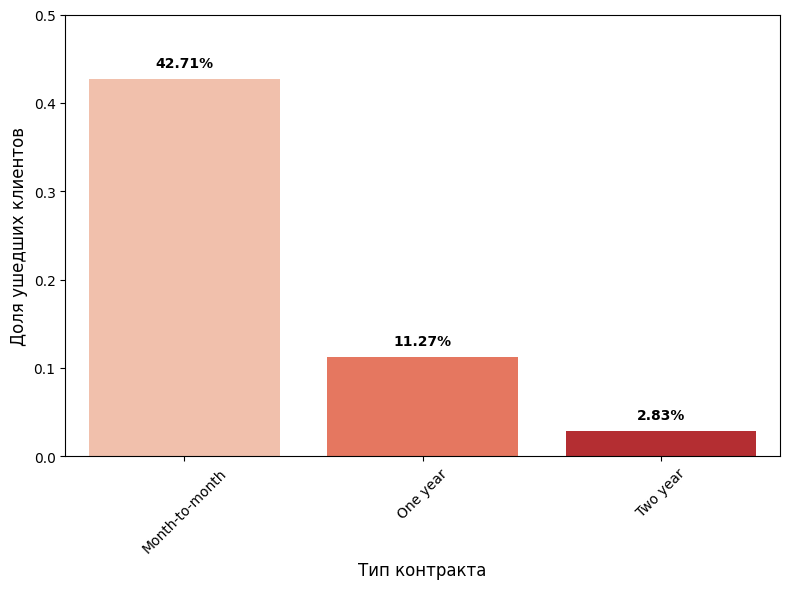

In [8]:
# Гипотеза 1: Влияние типа контракта
plt.figure(figsize=(8, 6))
contract_rates = pd.DataFrame({
    'Contract': ['Month-to-month', 'One year', 'Two year'],
    'Churn Rate': [month_to_month_churn_rate, one_year_churn_rate, two_year_churn_rate]
})
bars = sns.barplot(data=contract_rates, x='Contract', y='Churn Rate', palette='Reds')
plt.xlabel('Тип контракта', fontsize=12)
plt.ylabel('Доля ушедших клиентов', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 0.5)

# Добавляем значения на столбцы
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Дорогие тарифы увеличивают отток только у месячных клиентов?

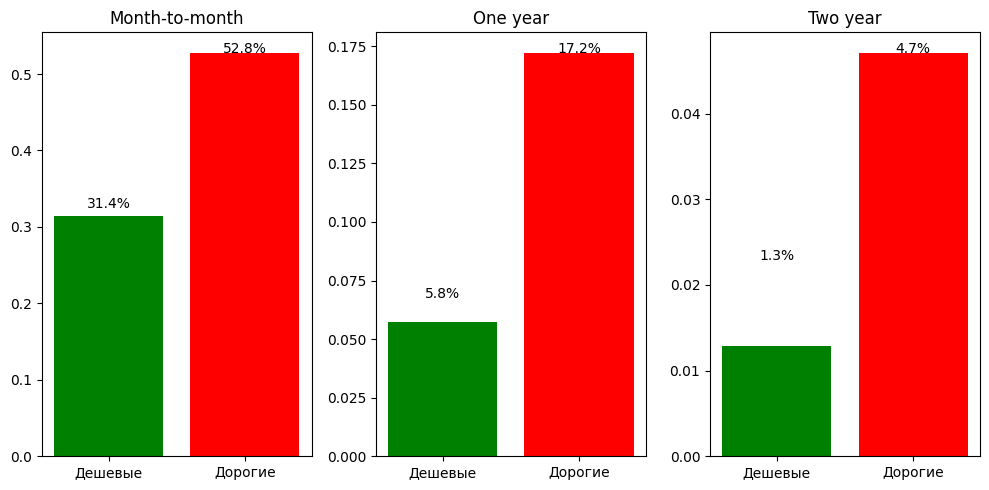

Вывод: Дорогие тарифы увеличивают отток ВО ВСЕХ группах.
Месячные: +68%
Годовые: +200%
Двухгодичные: +266%


In [9]:
import matplotlib.pyplot as plt

# Визуализация: отток на дорогих vs дешевых тарифах по контрактам
price_threshold = df['MonthlyCharges'].median()

plt.figure(figsize=(10, 5))

for i, contract in enumerate(['Month-to-month', 'One year', 'Two year'], 1):
    plt.subplot(1, 3, i)
    
    group = df[df['Contract'] == contract]
    cheap_churn = group[group['MonthlyCharges'] <= price_threshold]['Churn'].mean()
    expensive_churn = group[group['MonthlyCharges'] > price_threshold]['Churn'].mean()
    
    plt.bar(['Дешевые', 'Дорогие'], [cheap_churn, expensive_churn], color=['green', 'red'])
    plt.title(f'{contract}')
    
    # Подписи значений
    plt.text(0, cheap_churn + 0.01, f'{cheap_churn:.1%}', ha='center')
    plt.text(1, expensive_churn, f'{expensive_churn:.1%}', ha='center')

plt.tight_layout()
plt.show()

# Вывод
print("Вывод: Дорогие тарифы увеличивают отток ВО ВСЕХ группах.")
print(f"Месячные: +{((df[df['Contract']=='Month-to-month'][df['MonthlyCharges']>price_threshold]['Churn'].mean() / df[df['Contract']=='Month-to-month'][df['MonthlyCharges']<=price_threshold]['Churn'].mean() - 1)*100):.0f}%")
print(f"Годовые: +{((df[df['Contract']=='One year'][df['MonthlyCharges']>price_threshold]['Churn'].mean() / df[df['Contract']=='One year'][df['MonthlyCharges']<=price_threshold]['Churn'].mean() - 1)*100):.0f}%")
print(f"Двухгодичные: +{((df[df['Contract']=='Two year'][df['MonthlyCharges']>price_threshold]['Churn'].mean() / df[df['Contract']=='Two year'][df['MonthlyCharges']<=price_threshold]['Churn'].mean() - 1)*100):.0f}%")

### Влияние типа интернета на отток

СООТНОШЕНИЕ ПОПУЛЯРНОСТИ И ОТТОКА:
  Тип интернета  Количество клиентов  Процент оттока  Абсолютный отток
0   Fiber optic                 3096        0.418928            1297.0
1           DSL                 2421        0.189591             459.0
2   No internet                 1526        0.074050             113.0

Общее количество ушедших клиентов: 1869


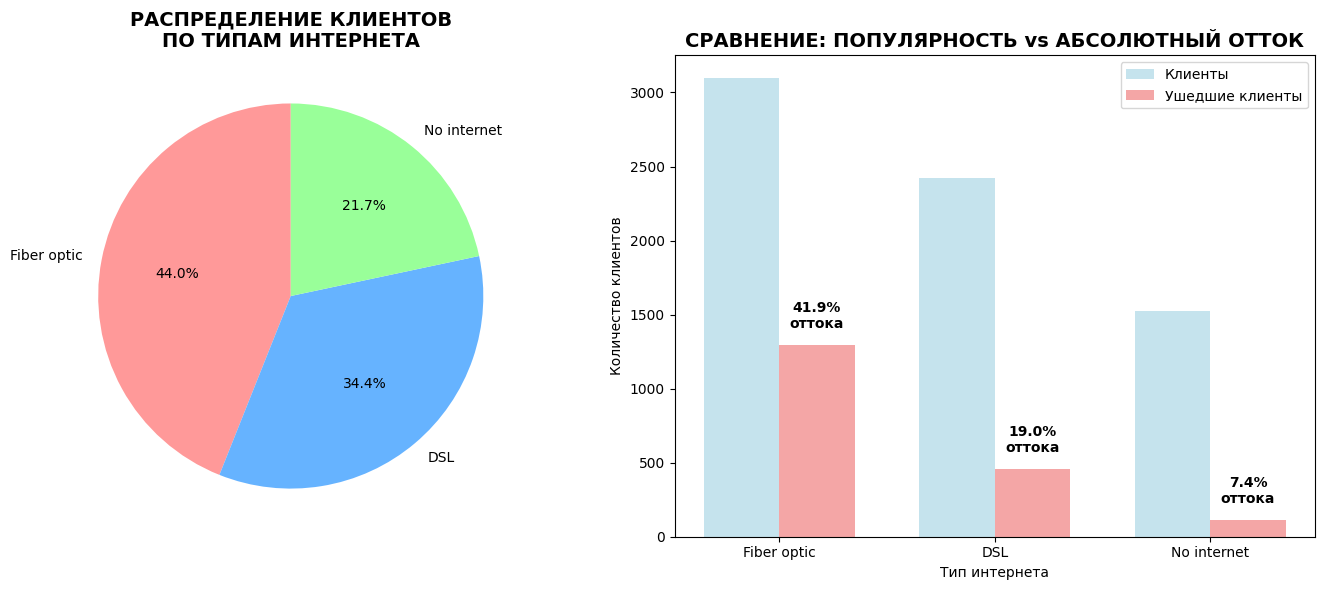

In [18]:
# Определим данные по типам интернета
fiber_data = df[df['InternetService'] == 'Fiber optic']
dsl_data = df[df['InternetService'] == 'DSL']
no_internet_data = df[df['InternetService'] == 'No']

# Соотношение оттока и популярности
print("СООТНОШЕНИЕ ПОПУЛЯРНОСТИ И ОТТОКА:")

# Рассчитываем проценты оттока для каждого типа
fiber_churn_rate = fiber_data['Churn'].mean()
dsl_churn_rate = dsl_data['Churn'].mean()
no_internet_churn_rate = no_internet_data['Churn'].mean()

internet_stats = pd.DataFrame({
    'Тип интернета': ['Fiber optic', 'DSL', 'No internet'],
    'Количество клиентов': [
        len(fiber_data),
        len(dsl_data),
        len(no_internet_data)
    ],
    'Процент оттока': [
        fiber_churn_rate,
        dsl_churn_rate,
        no_internet_churn_rate
    ],
    'Абсолютный отток': [
        len(fiber_data) * fiber_churn_rate,
        len(dsl_data) * dsl_churn_rate,
        len(no_internet_data) * no_internet_churn_rate
    ]
})

print(internet_stats)
print(f"\nОбщее количество ушедших клиентов: {internet_stats['Абсолютный отток'].sum():.0f}")

# 3. Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Распределение клиентов
colors = ['#ff9999', '#66b3ff', '#99ff99']
wedges1, texts1, autotexts1 = ax1.pie(internet_stats['Количество клиентов'], 
                                       labels=internet_stats['Тип интернета'],
                                       autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('РАСПРЕДЕЛЕНИЕ КЛИЕНТОВ\nПО ТИПАМ ИНТЕРНЕТА', fontsize=14, fontweight='bold')

# График 2: Сравнение оттока
x = np.arange(len(internet_stats))
width = 0.35

bars1 = ax2.bar(x - width/2, internet_stats['Количество клиентов'], width, 
                label='Клиенты', color='lightblue', alpha=0.7)
bars2 = ax2.bar(x + width/2, internet_stats['Абсолютный отток'], width, 
                label='Ушедшие клиенты', color='lightcoral', alpha=0.7)

ax2.set_title('СРАВНЕНИЕ: ПОПУЛЯРНОСТЬ vs АБСОЛЮТНЫЙ ОТТОК', fontsize=14, fontweight='bold')
ax2.set_xlabel('Тип интернета')
ax2.set_ylabel('Количество клиентов')
ax2.set_xticks(x)
ax2.set_xticklabels(internet_stats['Тип интернета'])
ax2.legend()

for i, (client_count, churned_count) in enumerate(zip(internet_stats['Количество клиентов'], 
                                                       internet_stats['Абсолютный отток'])):
    churn_percent = (churned_count / client_count) * 100
    
    # Позиция x для красного столбца
    red_bar_x = i + width/2

    text_height = churned_count + (max(internet_stats['Количество клиентов']) * 0.03)

    ax2.text(red_bar_x, text_height, 
             f'{churn_percent:.1f}%\nоттока', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

### Влияение времени жизни клиента на отток

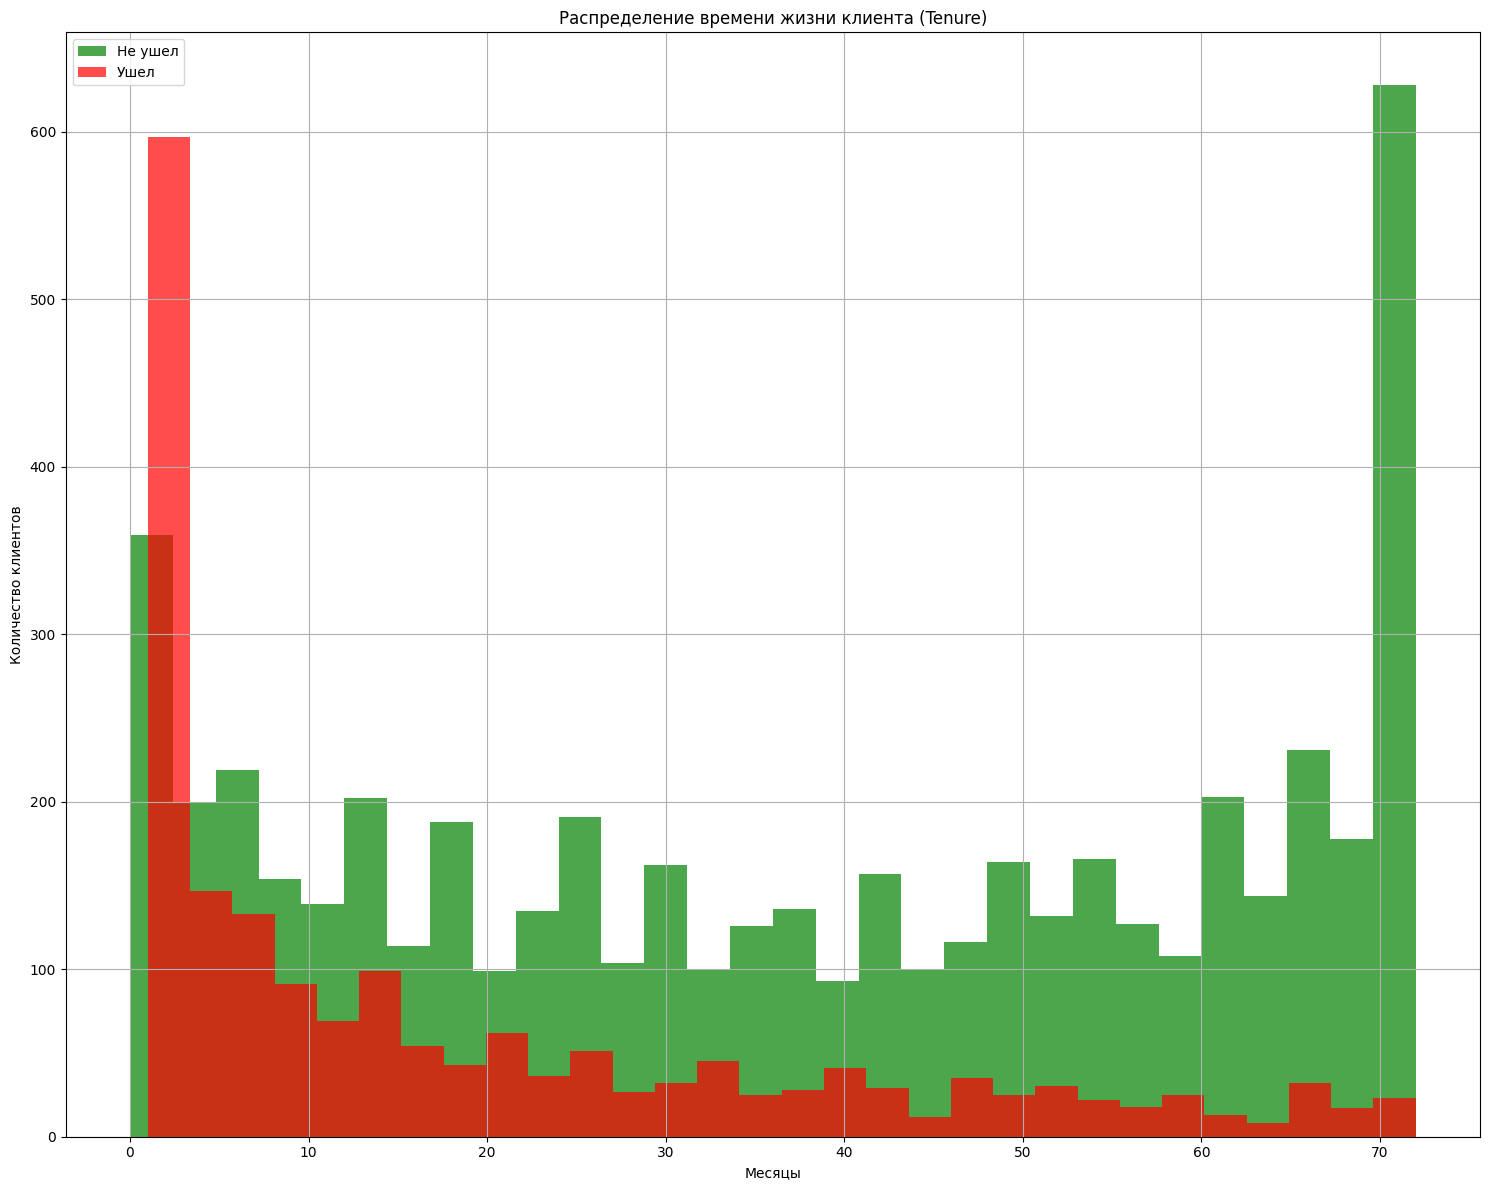

In [11]:
fig, axes = plt.subplots(figsize=(15, 12))

# tenure - отдельные гистограммы для каждой группы
df[df['Churn'] == 0]['tenure'].hist(bins=30, alpha=0.7, label='Не ушел', color='green')
df[df['Churn'] == 1]['tenure'].hist(bins=30, alpha=0.7, label='Ушел', color='red')
plt.title('Распределение времени жизни клиента (Tenure)')
plt.xlabel('Месяцы')
plt.ylabel('Количество клиентов')
plt.legend()


plt.tight_layout()
plt.show()

### Влияние способа оплаты на отток клиентов

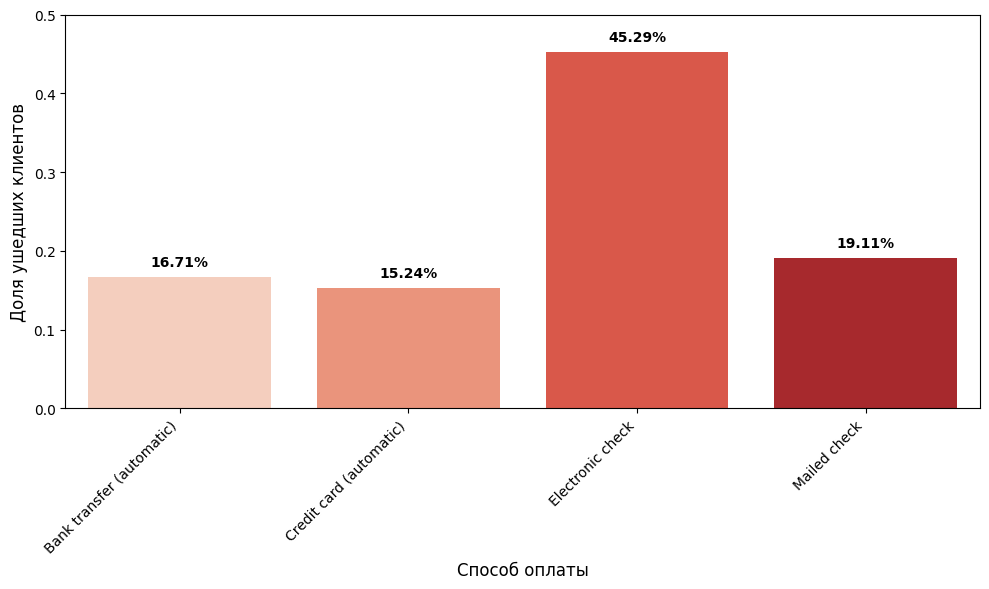

In [12]:
# Гипотеза 5: Способ оплаты
plt.figure(figsize=(10, 6))
payment_rates = []
for method in payment_churn_table.index:
    rate = payment_churn_table.loc[method, 1] / payment_churn_table.loc[method].sum()
    payment_rates.append({'Payment Method': method, 'Churn Rate': rate})
payment_rates_df = pd.DataFrame(payment_rates)
bars = sns.barplot(data=payment_rates_df, x='Payment Method', y='Churn Rate', palette='Reds')
plt.xlabel('Способ оплаты', fontsize=12)
plt.ylabel('Доля ушедших клиентов', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 0.5)

for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Влияние ежемесячных трат на отток

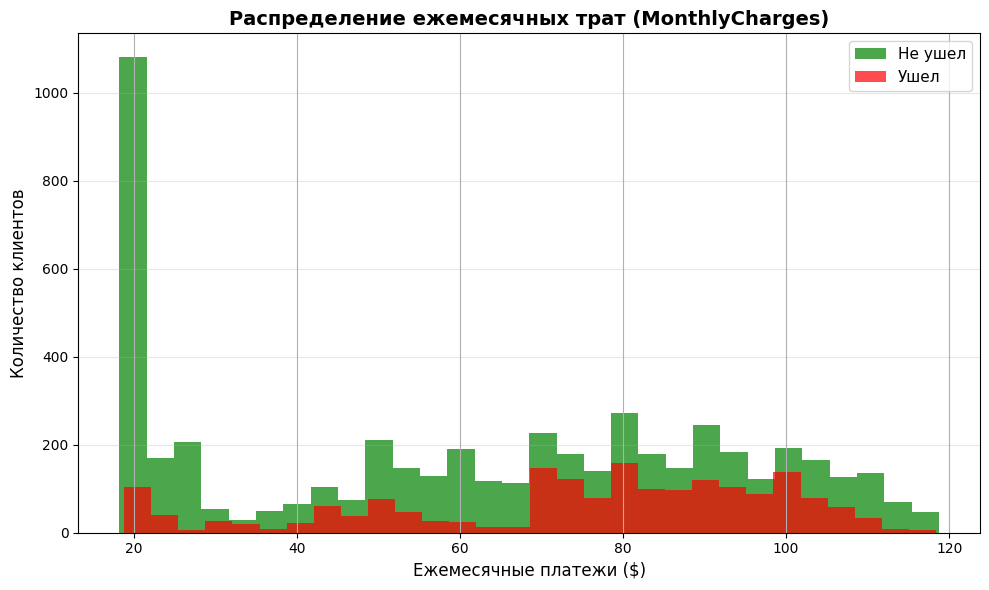

In [13]:
plt.figure(figsize=(10, 6))
df[df['Churn'] == 0]['MonthlyCharges'].hist(bins=30, alpha=0.7, label='Не ушел', color='green')
df[df['Churn'] == 1]['MonthlyCharges'].hist(bins=30, alpha=0.7, label='Ушел', color='red')
plt.title('Распределение ежемесячных трат (MonthlyCharges)', fontsize=14, fontweight='bold')
plt.xlabel('Ежемесячные платежи ($)', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Влияние техподдержки на отток клиентов

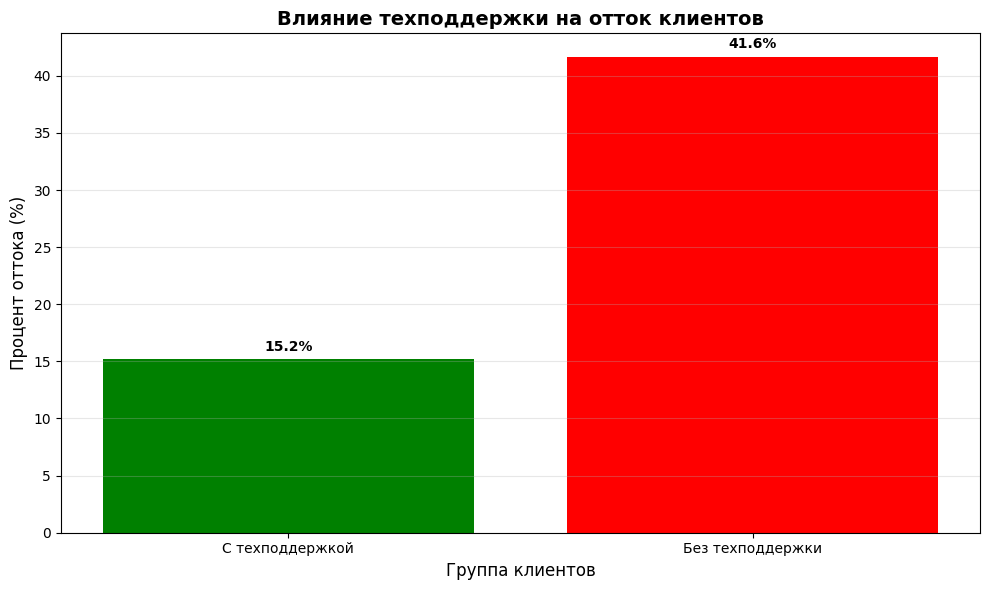

In [14]:
# Гипотеза 7: Влияние техподдержки на отток
techsupport_churn_table = pd.crosstab(df['TechSupport'], df['Churn'])

# Расчет процентов оттока
techsupport_yes_rate = techsupport_churn_table.loc['Yes', 1] / techsupport_churn_table.loc['Yes'].sum()
techsupport_no_rate = techsupport_churn_table.loc['No', 1] / techsupport_churn_table.loc['No'].sum()

# Создаем график
fig, ax = plt.subplots(figsize=(10, 6))

# Данные для визуализации
groups = ['С техподдержкой', 'Без техподдержки']
rates = [techsupport_yes_rate * 100, techsupport_no_rate * 100]
colors = ['green', 'red']

# Строим гистограмму
bars = ax.bar(groups, rates, color=colors)

# Настройки графика
ax.set_title('Влияние техподдержки на отток клиентов', fontsize=14, fontweight='bold')
ax.set_ylabel('Процент оттока (%)', fontsize=12)
ax.set_xlabel('Группа клиентов', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.show()

### Влияние пола на отток клиентов

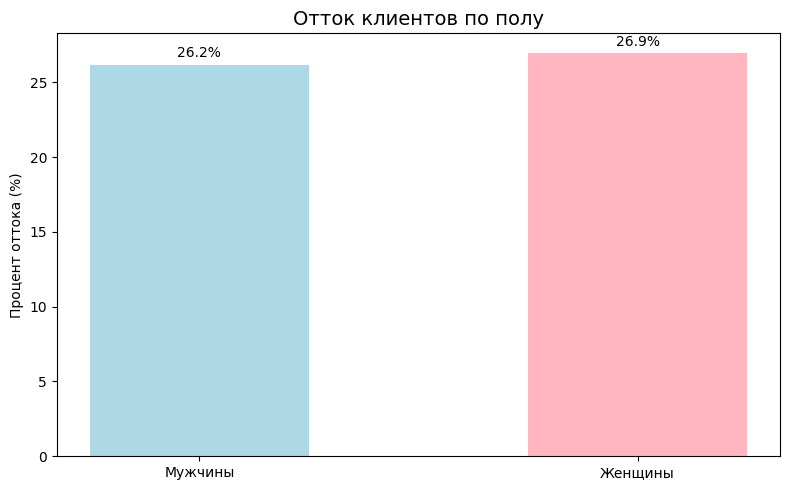

In [15]:
# Считаем отток по полу
male_churn = df[df['gender'] == 'Male']['Churn'].mean()
female_churn = df[df['gender'] == 'Female']['Churn'].mean()

fig, ax = plt.subplots(figsize=(8, 5))

groups = ['Мужчины', 'Женщины']
rates = [male_churn * 100, female_churn * 100]

bars = ax.bar(groups, rates, color=['lightblue', 'lightpink'], width=0.5)

ax.set_title('Отток клиентов по полу', fontsize=14)
ax.set_ylabel('Процент оттока (%)')

# Цифры на столбцах
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
            f'{rate:.1f}%', ha='center')

plt.tight_layout()
plt.show()